## regression_analysis.ipynb

This program reads data used in the California School Dashboard and performs linear regression analyses of percent of students who are socioeconomically disadvantaged on distance from standard on math and ELA among high schools.

Written by Stephen Lew

---

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

In [2]:
pd.options.mode.chained_assignment = None

#### Extract data

In [3]:
# Extract data on total enrollment and percent of students who are socioeconomically disadvantaged
df_enrollment = (pd.read_csv("https://www3.cde.ca.gov/researchfiles/cadashboard/censusenrollratesdownload2024.txt", sep = "\t", low_memory = False)
                 # Keep only records for schools. Drop district and state records.
                 .query("rtype == 'S'"))

In [4]:
# Keep the record with data on socioeconomically disadvantaged students if possible.
# Schools that do not have any socioeconomically disadvantaged students do not
# have such a record. For those schools, keep the first record and then set the
# percentage of socioeconomically disadvantaged students to zero.
df_enrollment["sed_record"] = np.where(df_enrollment["studentgroup"] == "SED", 1, 0)

In [5]:
df_enrollment = (df_enrollment.sort_values(["cds", "sed_record"], ascending = [True, False])
                 .groupby("cds")
                 .head(1))
# Data is now one record per school uniquely identified by cds

In [6]:
df_enrollment = df_enrollment.rename(columns = {"rate": "sed"})

In [7]:
df_enrollment["sed"] = df_enrollment["sed"].where(df_enrollment["sed_record"] == 1, 0)

In [8]:
df_enrollment = df_enrollment[["cds", "schoolname", "districtname", "totalenrollment", "sed"]]

In [9]:
# Extract data on distance from standard on math and ELA
def extract_assessments(subj, url):
    df_test = (pd.read_csv(f"{url}", sep = "\t", low_memory = False)
               # Keep only records for schools that have the data for all students.
               .query("rtype == 'S' and studentgroup == 'ALL'")
               # Data is now one record per school uniquely identified by cds.
               .rename(columns = {"currstatus": f"{subj}"}))
    df_test = df_test[["cds", f"{subj}"]]
    return df_test

In [10]:
df_math = extract_assessments(subj = "math", url = "https://www3.cde.ca.gov/researchfiles/cadashboard/mathdownload2024.txt")
df_ela = extract_assessments(subj = "ela", url = "https://www3.cde.ca.gov/researchfiles/cadashboard/eladownload2024.txt")

In [11]:
# Extract a list of high schools. High schools have a record in the graduation rate data
df_hs = (pd.read_csv("https://www3.cde.ca.gov/researchfiles/cadashboard/graddownload2024.txt", sep = "\t", low_memory = False)
         # Keep only records for schools. Drop district and state records.
         .query("rtype == 'S'"))
df_hs = (df_hs[["cds"]]
         .groupby("cds")
         .head(1))
# Data is now one record per school uniquely identified by cds

#### Integrate data

In [12]:
df_analysis = (df_hs.merge(df_enrollment, on = "cds", how = "inner")
               .merge(df_math, on = "cds", how = "left")
               .merge(df_ela, on = "cds", how = "left"))

#### Data analysis

In [13]:
# Remove cases that are missing data on distance from standard on math
df_analyze_math = df_analysis[df_analysis["math"].notna()]

In [14]:
# Linear regression analyses of percent of students who are socioeconomically
# disadvantaged on distance from standard on math among high schools. Total
# enrollment is used as the analytic weight.
math_model = linear_model.LinearRegression()
math_model.fit(df_analyze_math[["sed"]], df_analyze_math["math"], sample_weight = df_analyze_math["totalenrollment"])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [15]:
df_analyze_math["math_predicted"] = math_model.predict(df_analyze_math[["sed"]])
df_analyze_math["math_resid"] = df_analyze_math["math"] - df_analyze_math["math_predicted"]

Text(0, 0.5, 'Points from Standard in Math')

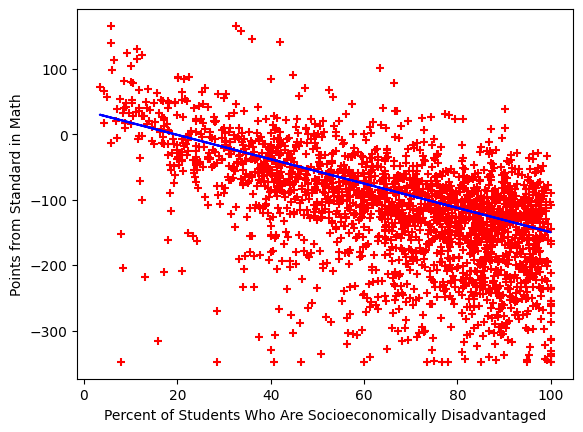

In [16]:
%matplotlib inline
plt.scatter(df_analyze_math["sed"], df_analyze_math["math"], color = "red", marker = "+")
plt.plot(df_analyze_math["sed"], df_analyze_math["math_predicted"], color = "blue")
plt.xlabel("Percent of Students Who Are Socioeconomically Disadvantaged")
plt.ylabel("Points from Standard in Math")

In [17]:
# Remove cases that are missing data on distance from standard on ELA
df_analyze_ela = df_analysis[df_analysis["ela"].notna()]

In [18]:
# Linear regression analyses of percent of students who are socioeconomically
# disadvantaged on distance from standard on ELA among high schools. Total
# enrollment is used as the analytic weight.
ela_model = linear_model.LinearRegression()
ela_model.fit(df_analyze_ela[["sed"]], df_analyze_ela["ela"], sample_weight = df_analyze_ela["totalenrollment"])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [19]:
df_analyze_ela["ela_predicted"] = ela_model.predict(df_analyze_ela[["sed"]])
df_analyze_ela["ela_resid"] = df_analyze_ela["ela"] - df_analyze_ela["ela_predicted"]

Text(0, 0.5, 'Points from Standard in ELA')

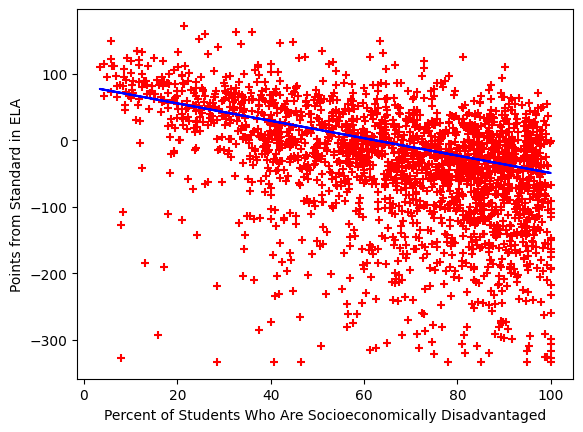

In [20]:
%matplotlib inline
plt.scatter(df_analyze_ela["sed"], df_analyze_ela["ela"], color = "red", marker = "+")
plt.plot(df_analyze_ela["sed"], df_analyze_ela["ela_predicted"], color = "blue")
plt.xlabel("Percent of Students Who Are Socioeconomically Disadvantaged")
plt.ylabel("Points from Standard in ELA")

In [21]:
df_analyze_math = df_analyze_math[["cds", "math_predicted", "math_resid"]]
df_analyze_ela = df_analyze_ela[["cds", "ela_predicted", "ela_resid"]]

In [22]:
df_analysis = df_analysis.merge(df_analyze_math, on = "cds", how = "left")
df_analysis = df_analysis.merge(df_analyze_ela, on = "cds", how = "left")
df_analysis.to_csv(r"C:\Users\Public\Documents\regression_analysis_python.csv", index = False)